# Sampling particles from a yt dataseries for inTRACKtive visualization

This notebook extracts particle positions from a yt dataseries and writes out an 
intermediate CSV file that can be further processed using the utilities provided
by [inTRACKtive](https://github.com/royerlab/inTRACKtive). 

![](static/intrackive_yt_04.png)

## Table of Contents
1. [Requirements](#1.-Requirements)
2. [Sample Data](#2.-Sample-Data)
3. [Data Processing Setup](#3.-Data-Processing-Setup)
4. [Processing yt timesteps with Dask](#4.-Processing-yt-timesteps-with-Dask)
5. [Final Processing and Cleanup](#5.-Final-Processing-and-Cleanup)
6. [What next](#6.-What-next)

## 1. Requirements 

The Python requirements for this notebook and for the subsequent data processing steps with the inTRACKtive utilities are as follows:

In [1]:
with open('./requirements.txt') as fi:
    print(fi.read())

scipy
zarr
numpy
yt[enzo]
h5py
pooch
pandas
jupyterlab
dask[distributed]
bokeh


In [2]:
import yt 
import numpy as np 
import pandas as pd
import dask 
from dask.distributed import Client
from pathlib import Path 

Additionally, you'll want to clone the inTRACKtive repo, [https://github.com/royerlab/inTRACKtive/](https://github.com/royerlab/inTRACKtive/), to further process the outputs from this notebook using the included [tools](https://github.com/royerlab/inTRACKtive/tree/main/tools). 

## 2. Sample Data 

For sample data, we'll use the full `Enzo_64` dataset from the [yt sample data](https://yt-project.org/data/) -- note that you'll want to manually download the data since `yt.load_sample()` will only fetch a subset of `Enzo_64`. 

In [3]:
import yt 

yt.set_log_level(50)

ts = yt.load("Enzo_64/DD????/data????")

In [4]:
print(len(ts))

44


Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17230.96it/s]



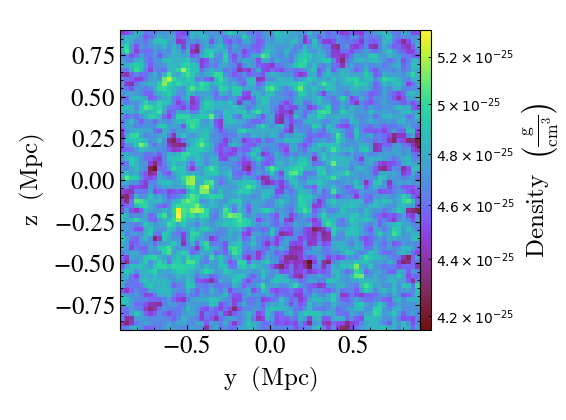

Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 22690.30it/s]



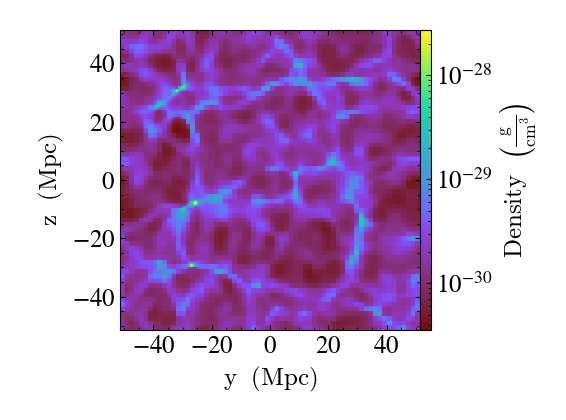

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 6538.72it/s]



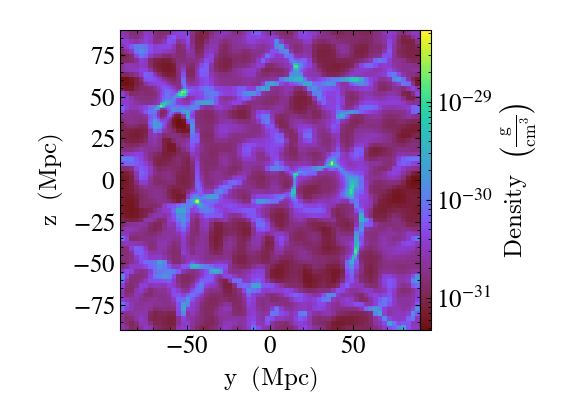

In [5]:
for tid in [0, 22, 43]: 
    slc = yt.SlicePlot(ts[tid], 'x', ('gas', 'density'), window_size = (3,3))
    slc.show()

In [6]:
# available particle fields
[fld for fld in ts[0].field_list if fld[0]=='io']

Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25065.56it/s]


[('io', 'creation_time'),
 ('io', 'dynamical_time'),
 ('io', 'metallicity_fraction'),
 ('io', 'particle_index'),
 ('io', 'particle_mass'),
 ('io', 'particle_position_x'),
 ('io', 'particle_position_y'),
 ('io', 'particle_position_z'),
 ('io', 'particle_type'),
 ('io', 'particle_velocity_x'),
 ('io', 'particle_velocity_y'),
 ('io', 'particle_velocity_z')]

Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21345.06it/s]



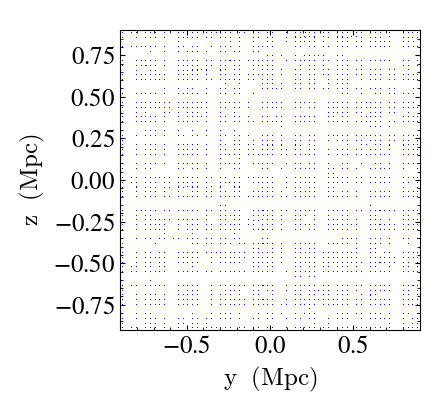

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 3846.07it/s]



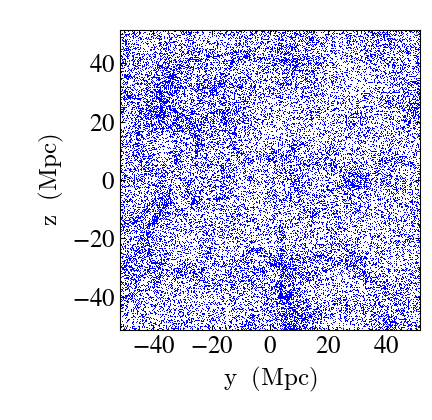

Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 24890.44it/s]



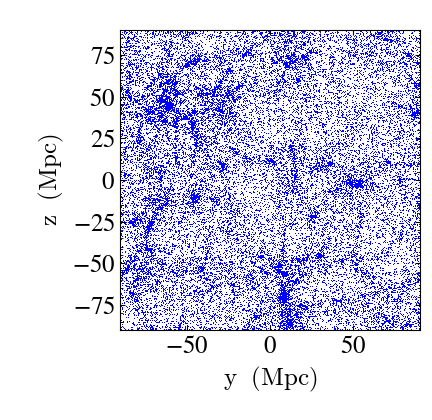

In [7]:
for tid in [0, 22, 43]: 
    pp = yt.ParticlePlot(ts[tid], 
                          ('io', 'particle_position_y'), 
                          ('io', 'particle_position_z'), 
                         window_size=(3,3)
                         )
    pp.show()

# 3. Data Processing Setup

So for each timestep we want to exact the partile positions and write them to a CSV file of the format expected by the inTRACKtive. Rather than writing all of the particles, we'll select a subset. We could do this in many ways, but one interesting approach is to find all the particles falling within a sphere in the final timestep and then only output those corresponding particles at each timestep. 

So let's first pick out a high density region from the final timestep to encapsulate:

Parsing Hierarchy : 100%|█████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 23235.94it/s]



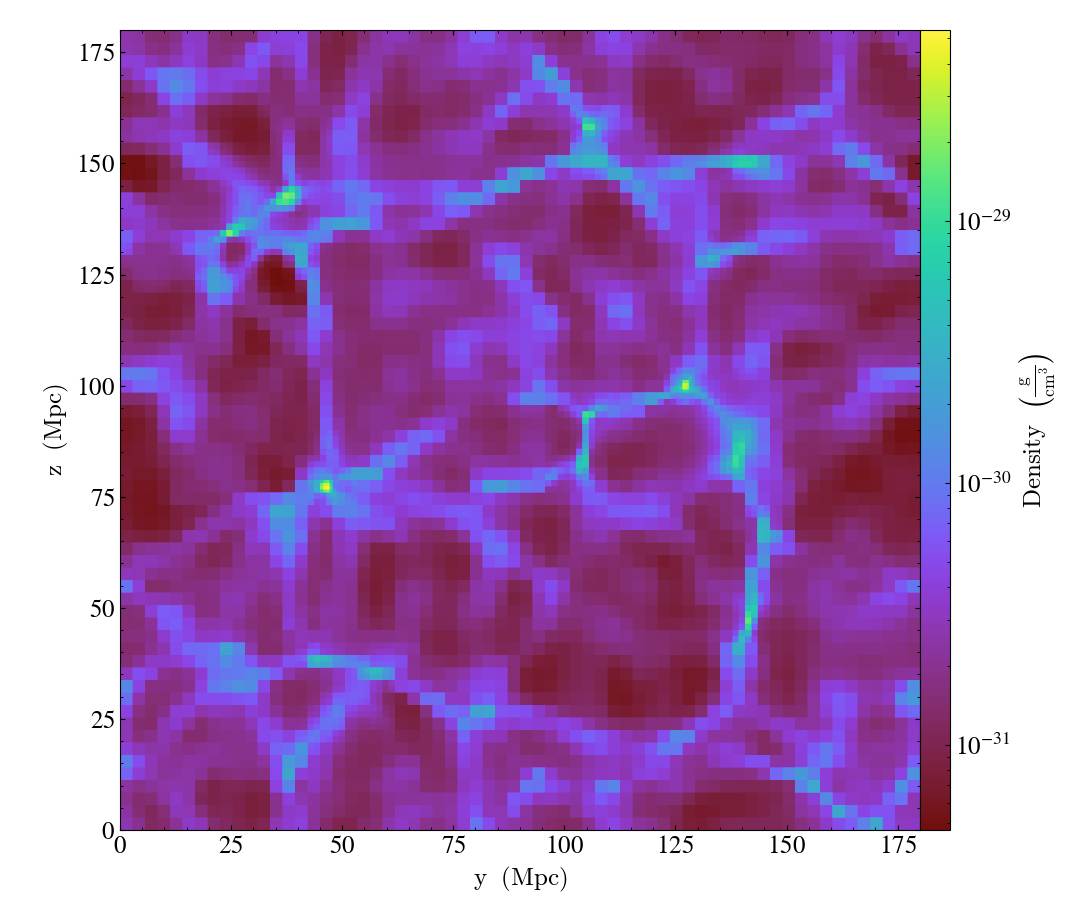

unyt_array([0.5       , 0.27773011, 0.41659517], 'code_length')

In [8]:
ds = ts[-1]
slc = yt.SlicePlot(ds, 'x', ('gas', 'density'), origin='native')
slc.show()
pos = ds.arr(np.array([ds.domain_center[0].to('Mpc').d, 50., 75.]), 'Mpc').to('code_length')
pos

and then store the particle id's falling within a distance of 0.1 code_length of that point. We'll put it into a pandas dataframe so we can join with it later to quickly identify the particle id's (we're also renaming the particle index to `track_id` to match expected format, explained further below). 

In [9]:
select_radius = 0.1
sp = ds.sphere(pos, select_radius)
df_ids = pd.DataFrame({'track_id': sp['io', 'particle_index'].astype(np.int64)})
df_ids

,track_id
0,152960
1,152961
2,152994
3,153024
4,153059
...,...
3342,186142
3343,186143
3344,186173
3345,186174


now we're ready to build up the functions for our dask workflow! 

Our target is to have a funciton that is easy to distribute across many processes, so what we'll aim for is the following: 

```
def sample_timestep(ds_fname, t_index, save_dir):
    yt.set_log_level(50)    
    
    # load the current ds
    ds = yt.load(ds_fname)

    # get the data
    particle_data = extract_particle_data(ds)
    
    # write the data. 
    write_data(ds, particle_data, t_index, save_dir)
    
    return particle_data['track_id'].size
```

The final `write_data` will output a CSV with the following format expected by the inTRACKtive conversion tools (see [here](https://github.com/royerlab/inTRACKtive?tab=readme-ov-file#i-convert-the-cell-tracking-data-into-our-zarr-format) for more): 


    |   track_id |   t |   z |   y |   x |   parent_track_id |
    |-----------:|----:|----:|----:|----:|------------------:|
    |          1 |   0 | 361 | 415 | 266 |                -1 |
    |          1 |   1 | 364 | 419 | 269 |                -1 |
    |          2 |   2 | 331 | 421 | 259 |                 1 |
    |          2 |   3 | 335 | 397 | 265 |                 1 |
    |          2 |   4 | 334 | 390 | 275 |                 1 |
    |          3 |   2 | 422 | 405 | 291 |                 1 |
    |          3 |   3 | 423 | 400 | 300 |                 1 |
    |          3 |   4 | 419 | 398 | 302 |                 1 |


We'll not worry about tracks merging or splitting here, so we'll set `parent_track_id` to -1 for all tracks. 

Note that the driving function, `sample_timestep`,  accepts a filename for a particular timestep, rather than a full yt datset. This is because we're going to use `dask.delayed` to build up our parallel workflow, and dask must serialize arguments (using pickle by default) so it's much easier to pass along `ds_fname` instead of an instantiated yt `ds` (pickling yt Datasets does not always behave as expected). 

Ok, so first we'll write a function that takes an active dataset and returns a dictionary of particle positions. This functions applies a sphere sub-selection to cut down on the particles read in. It's centered on the same center, but larger by a factor of 3 to make sure we'll pull in the particle id's of interest (you may want to adjust this parameter). 

In [10]:
sp_selector = {'center': pos.d.copy(), 'radius':select_radius * 3 }  # code length

def extract_particle_data(ds):
    flds = [f"particle_position_{ax}" for ax in "xyz"]
    flds += ['particle_index',]

    center = ds.arr(sp_selector['center'], 'code_length')
    rad = ds.quan(sp_selector['radius'], 'code_length')
    sp = ds.sphere(center, rad)

    # build a dict to rename the fields to expected columns for an inTRACKtive csv
    fld_rename = {fld: fld.replace('particle_','').replace('position_','') for fld in flds}
    fld_rename['particle_index']='track_id'

    # actually read the data, adjusting names
    particle_data = {}
    for fld in flds: 
        particle_data[fld_rename[fld]] = sp[('io', fld)]

    # cast the track id to int
    particle_data['track_id'] = particle_data['track_id'].astype(np.int64)
    
    return particle_data

Now a function to store the data dictionary in a Pandas dataframe, setting the additional `parent_track_id` and `t` index columns:

In [11]:
def get_dataframe(ds, particle_data, t_index): 
    import pandas as pd 
        
    particle_data['parent_track_id'] = np.full(particle_data['x'].shape, -1, dtype=np.int8)
    particle_data['t'] = np.full(particle_data['x'].shape, t_index, dtype=np.int32)
    return pd.DataFrame(particle_data)

And finally the function to actually write out the data for the current timestep. This function also includes an additinional join with the `df_ids` dataframe we built initially. It's worth pointing out that this will result in dask serializing `df_ids` to use in all the processes -- not ideal if `df_ids` is very large. So you may want to refactor this if you are extending this notebook and selecting a much larger number of particles initially to avoid that communication overhead.

In [12]:
def write_data(ds, particle_data, t_index, save_dir):
    # first go: write intermediate csv then use the conversion scripts    
    
    out_fi = Path(save_dir) / Path(f"t_{t_index}.csv")    
    df = get_dataframe(ds, particle_data, t_index) 

    df_out = pd.merge(df_ids, df, on='track_id', how='inner')
    df_out.to_csv(out_fi, index=False)

ok, now we're ready to actually define our `sample_timstep` function:

In [13]:
def sample_timestep(ds_fname, t_index, save_dir):
    yt.set_log_level(50)    
    
    # load the current ds
    ds = yt.load(ds_fname)

    # get the data
    particle_data = extract_particle_data(ds)
    
    # write the data. "
    write_data(ds, particle_data, t_index, save_dir)
    
    return particle_data['track_id'].size

mainly to have something to look at, we also return the number of particles selected.

## 4. Processing yt timesteps with Dask

Now we're ready to process the timesteps! The end result of this step will be a bunch of CSV files, one for each step, that we'll need to subsequently merge. 

First let's extract the filenames we want:

In [14]:
fnames = [ds.filename for ds in ts]

and setup a directory to save data to:

In [15]:
save_dir = Path(yt.config.ytcfg.get('yt', 'test_data_dir')) / 'Enzo_64_particles'
if not save_dir.is_dir():
    save_dir.mkdir() 

now let's build up our dask graph:

In [16]:
n_particles_v_time = [] 
for ifile, fname in enumerate(fnames):
    n_particles_v_time.append(dask.delayed(sample_timestep)(fname, ifile, save_dir))

From here, you could just call `dask.compute(*n_particles_v_time)`, but I'll spin up a cluster manually to control the number of workers and threads per worker (since we're processing independent timesteps, this is actually thread-safe operation for yt!). 

In [17]:
c = Client( n_workers=4, threads_per_worker=2)

In [18]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33409,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:35753,Total threads: 2
Dashboard: http://127.0.0.1:38865/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:35957,


let's go! 

In [19]:
%%time
n_particles_v_time = dask.compute(*n_particles_v_time)

Parsing Hierarchy : 100%|██████████| 697/697 [00:00<00:00, 4538.88it/s]


CPU times: user 669 ms, sys: 56.1 ms, total: 725 ms
Wall time: 13 s


Let's check out how many particles we're picking up at each timestep: 

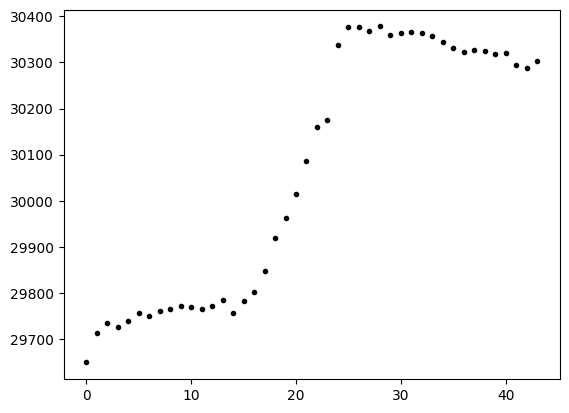

In [20]:
import matplotlib.pyplot as plt 
plt.plot(n_particles_v_time,'.k')

In [21]:
c.close()

## 5. Final Processing and Cleanup

So now we've got to merge all our csv files into one big one. There may be a way to do this with dask (or dask dataframes), but since we're writing to a single file it can get tricky, so we'll just do this manually. 

In [22]:
import os 
import pandas as pd 

full_file = 'full_timeseries.csv'
write_mode = 'w'
write_header = True
files_to_rm = []
for fname in os.listdir(save_dir):
    if fname == full_file or not fname.endswith('.csv'):
        continue 

    # read the current file 
    df = pd.read_csv(save_dir / fname)
    
    # write it to the big file
    df.to_csv(save_dir / full_file, index=False, mode=write_mode, header=write_header)
    write_mode = 'a' # switch to append!
    write_header = False  # and avoid writing the header again
    # add the file to the to-remove list
    files_to_rm.append(save_dir / fname)

and now let's read back in the full file, sort it and re-write it

In [23]:
df = pd.read_csv(save_dir / full_file)
df = df.sort_values('track_id')
df.to_csv(save_dir / full_file, index=False)

and delete all those intermediate csv files

In [24]:
for fi in files_to_rm:
    if os.path.isfile(fi):
        os.remove(fi)

In [25]:
print(save_dir / full_file)

/home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/full_timeseries.csv


## 6. What next


### Final data conversion 

So now you're ready to actually use the [tools](https://github.com/royerlab/inTRACKtive/tree/main/tools) provided by the inTRACKtive repo. Go clone it if you haven't then `cd` into `inTRACKtive/tools` and run `convert_tracks_csv_to_sparse_zarr.py` to run a final conversion that takes the intermediate CSV file we just created and outputs a zarr file in the format expected by inTRACKtive.


Checking the help: 


```shell
python convert_tracks_csv_to_sparse_zarr.py --help

usage: convert_tracks_csv_to_sparse_zarr.py [-h] [--add_radius]
                                            csv_file [out_dir]

Convert a CSV of tracks to a sparse Zarr store

positional arguments:
  csv_file      Path to the CSV file
  out_dir       Path to the output directory (optional, defaults to the parent
                dir of the CSV file)
```

So we can use this like:

```
$ python convert_tracks_csv_to_sparse_zarr.py /home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/full_timeseries.csv /home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/
```
running this results in the following output:

```shell
add_radius False
num_values_per_point (z,y,x,radius) 3
3D dataset
Read 147268 points in 0.34143262077122927 seconds
Warning: track_ids not consecutive (3347 track_IDs found, max track_id = 261924)
Solution: Track_id are reformatted to be consecutive from 1 to N, with N the number of tracks
Munged 147268 points in 0.5341507280245423 seconds
Chased track lineage forward in 0.00026105204597115517 seconds (0 iterations)
Chased track lineage backward in 0.00012947572395205498 seconds (0 iterations)
Converted to CSR in 0.11718614585697651 seconds
Saved to Zarr in 0.196058614179492 seconds

```

and we'll have a new `.zarr` file in our directory:

```shell
$ ls /home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/
full_timeseries_bundle.zarr  full_timeseries.csv
```

### Serving the data 

To actually use the new zarr file in inTRACKtive, we need to serve that file locally, for which we can use the `serve_directory_http.py` tool: 

```
python serve_directory_http.py --help
usage: Serves data on the file system over HTTP bypassing CORS [-h] [--host HOST] [--port PORT] dir

positional arguments:
  dir          The directory on the filesystem to serve
```

You want to provide the path to the actual `.zarr`, e.g.: 

```
python serve_directory_http.py /home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/full_timeseries_bundle.zarr
```

which will output 

```shell
INFO:root:Serving /home/chavlin/hdd/data/yt_data/yt_sample_sets/Enzo_64_particles/full_timeseries_bundle.zarr at http://127.0.0.1:8000
```


### Running inTRACKtive locally 

Since you had to clone the inTRACKtive repo to use the tools, you might as well run the full app locally as well! If you don't want to bother, you can try using the active instance at [https://intracktive.sf.czbiohub.org/](https://intracktive.sf.czbiohub.org/) but why not run locally?? 

All you need is an installation of `nodejs`. If you are already using a conda environment, you can just run

```
conda install nodejs
```
if you're not on conda, there are many options for installing on your system available at https://nodejs.org/en/download/prebuilt-installer 

Once you have `nodejs`, you'll need to go into your inTRACKtive repo directory and then install dependencies:

```
npm install
```

and then run the app with

```
npm run dev
```

### Loading in inTRACKtive

To actually load in inTRACKive, all you have to do is hit the litte world icon: 

![](static/intrackive_yt_01.png)

and supply the address of your local file server (`http://127.0.0.1:8000` in the above output)

![](static/intrackive_yt_02.png)

hit apply and your data will get loaded in 

![](static/intrackive_yt_03.png)

from which you can walk through timesteps and select particles to load track for

![](static/intrackive_yt_04.png)